<a href="https://colab.research.google.com/github/Sabelz/Master_Thesis_Alexander/blob/main/GPs/ToyGPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Processes on the Toy dataset

# Mount to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Master_Thesis_Alexander
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Master_Thesis_Alexander


# Imports

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander


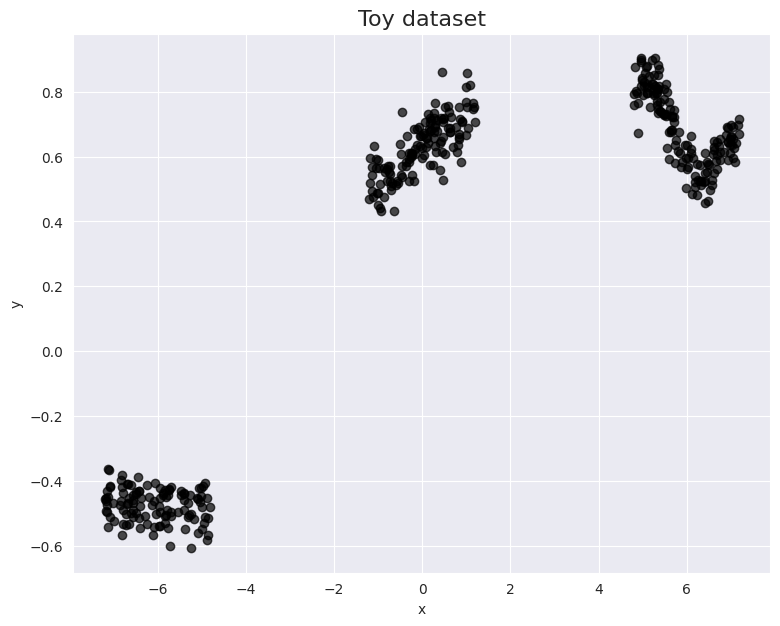

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Master_Thesis_Alexander
----------------------------------------------------------
ALL MODELS: 
KISS-GP For 1D-4D data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

KISS-GP For higher dimensional data:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.ConstantMean()
      kernel = gpytorch.kernels.RBFKernel()
      model = KISSGP_NDim(x_train, y_train, likelihood, mean, kernel)
      model = model.to(device) # Move model to device

 Variational GP:
    Example:
      likelihood = gpytorch.likelihoods.GaussianLikelihood()
      mean = gpytorch.means.Const

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch > \dev\null # Suppress prints
import gpytorch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import jax
import jax.numpy as jnp
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run "datasets/toy.ipynb" # Run the Toy notebook
%run "utils/models.ipynb" # Run the models notebook
%run "utils/functions.ipynb" # Run the functions notebook

# Training Data from Toy

In [3]:
x_toy , y_toy = x, y # x, y are defined in ../datasets/Toy.ipynb¨
print(len(x_toy), len(y_toy))
x_train_toy, x_test_toy, y_train_toy, y_test_toy = train_test_split(x_toy, y_toy, test_size=0.2, random_state=666)
# Transform into tensors
x_train_toy, x_test_toy, y_train_toy, y_test_toy = (
torch.from_numpy(x_train_toy), torch.from_numpy(x_test_toy),
torch.from_numpy(y_train_toy), torch.from_numpy(y_test_toy))

400 400


# Define the KISS-GP model

In [4]:
KISSGP_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
KISSGP_mean_toy = gpytorch.means.ConstantMean() # Mean
KISSGP_kernel_toy = gpytorch.kernels.RBFKernel() # Kernel
KISSGP_model_toy = KISSGP(x_train_toy, y_train_toy, KISSGP_likelihood_toy, KISSGP_mean_toy, KISSGP_kernel_toy) # KISSGP defined in utils/Models.ipynb

# Train the KISS-GP Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:618.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


4.3070313930511475


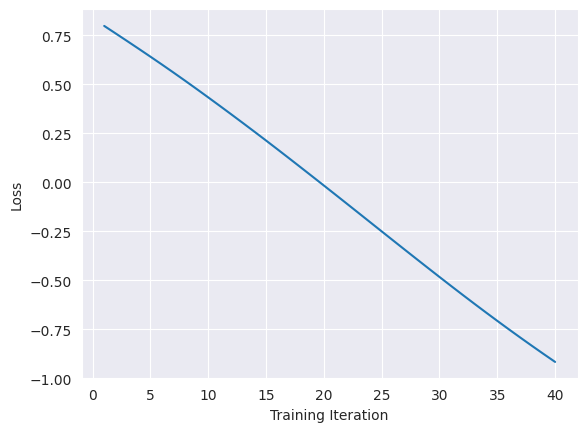

In [5]:
train_time_KISSGP_toy = train(KISSGP_model_toy, KISSGP_likelihood_toy, x_train_toy, y_train_toy, training_iter= 40) # train is defined in utils/functions.ipynb
print(train_time_KISSGP_toy)

# Plot KISS-GP Model

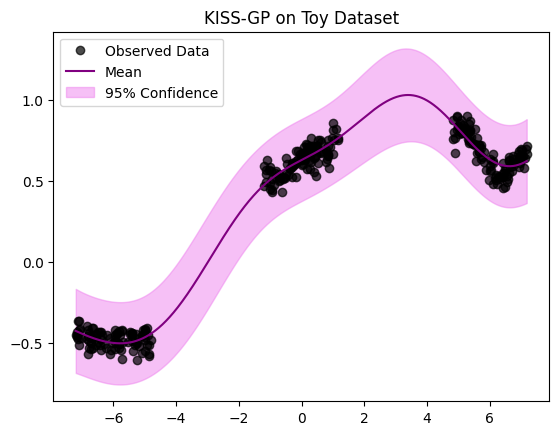

In [6]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, KISSGP_model_toy, KISSGP_likelihood_toy, "KISS-GP on Toy Dataset")

# Predict and Evaluate KISS-GP

In [7]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_KISSGP_toy = predict(KISSGP_model_toy, KISSGP_likelihood_toy,
                                     x_test_toy) # predict is defined in utils/functions.ipynb
  RMSE_KISSGP_toy, NLPD_KISSGP_toy, PICP_KISSGP_toy, MPIW_KISSGP_toy = error_metrics(
      x_test_toy,
      y_test_toy,
      predictions_KISSGP_toy.mean,
      predictions_KISSGP_toy.variance)# error_metrics defined in utils/functions.ipynb


  print("RMSE KISS-GP: ",RMSE_KISSGP_toy)
  print("NLPD KISS-GP: ",NLPD_KISSGP_toy)
  print("PICP KISS-GP: ",PICP_KISSGP_toy)
  print("MPIW KISS-GP: ",MPIW_KISSGP_toy)
  print("Time KISS-GP: ", train_time_KISSGP_toy)

RMSE KISS-GP:  0.06443032417243247
NLPD KISS-GP:  tensor(-0.9975, dtype=torch.float64)
PICP KISS-GP:  1.0
MPIW KISS-GP:  0.5101631461087395
Time KISS-GP:  4.3070313930511475


# Variational Model -------------------------------------------------------

In [8]:
variational_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood()
variational_mean_toy = gpytorch.means.ConstantMean()
variational_kernel_toy = gpytorch.kernels.RBFKernel()
n_inducing_points = 20
inducing_points = x_train_toy[torch.randperm(x_train_toy.size(0))[:n_inducing_points]]
variational_model_toy = variationalGP(variational_likelihood_toy, variational_mean_toy, variational_kernel_toy, inducing_points) # variationalGP defined in utils/models.ipynb
variational_model_toy = variational_model_toy.to(device) # Move model to device, defined in utils/models.ipynb

# Train the Variational model

Training Time:  0.8192591667175293


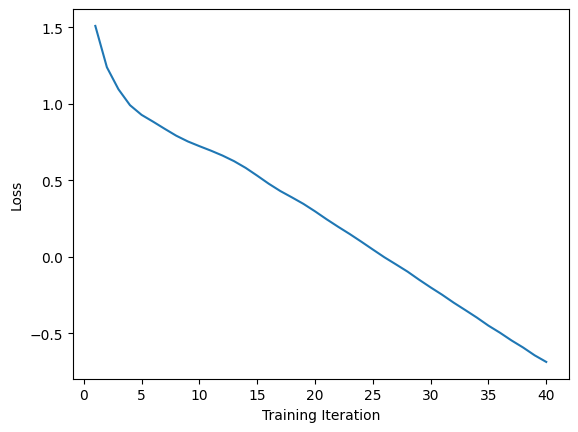

In [9]:
train_time_variational_toy = train_ELBO(variational_model_toy, variational_likelihood_toy, x_train_toy, y_train_toy, training_iter= 40) # train is defined in utils/functions.ipynb
print("Training Time: ",train_time_variational_toy)

# Plot Variational Model

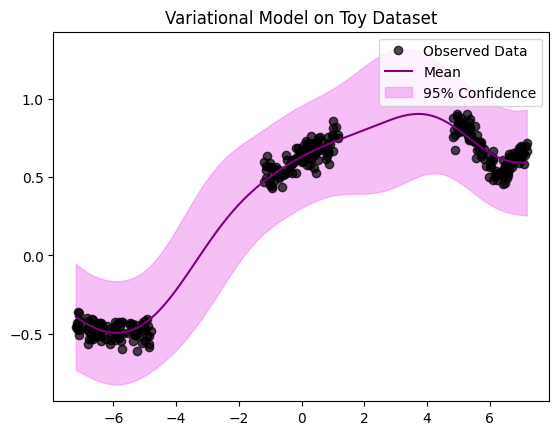

In [10]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, variational_model_toy, variational_likelihood_toy, "Variational Model on Toy Dataset")

# Predict and Evaluate Variational Model

In [11]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # predict is defined in utils/functions.ipynb
  predictions_variational_toy = predict(variational_model_toy, variational_likelihood_toy, x_test_toy)

  RMSE_variational_toy, NLPD_variational_toy, PICP_variational_toy, MPIW_variational_toy = error_metrics(
      x_test_toy,
      y_test_toy,
      predictions_variational_toy.mean,
      predictions_variational_toy.variance)# error_metrics defined in utils/functions.ipynb
  print("RMSE variational Model: ",RMSE_variational_toy)
  print("NLPD variational Model: ",NLPD_variational_toy)
  print("PICP variational Model: ",PICP_variational_toy)
  print("MPIW variational Model: ",MPIW_variational_toy)
  print("Time variational Model: ", train_time_variational_toy)

RMSE variational Model:  0.06734846402751819
NLPD variational Model:  tensor(-0.7807, dtype=torch.float64)
PICP variational Model:  1.0
MPIW variational Model:  0.6615017947570895
Time variational Model:  0.8192591667175293


# State Space Model, optimized

In [12]:
# To do the regression in state space, we need to rearrange the datapoints in temporal order
n_test_points = len(x_test_toy)
all_points = jnp.concatenate([x_train_toy.numpy(), x_test_toy.numpy()])
temporal_order = jnp.argsort(all_points)

# State Space X's and Y's
ss_xs_toy = all_points[temporal_order]
ss_ys_toy = jnp.concatenate([y_train_toy.numpy(), jnp.nan * jnp.ones((n_test_points, ))])[temporal_order]

# Compute the equivalent SS model
t0 = min(x_train_toy).numpy().item()
dts_toy = jnp.diff(ss_xs_toy, prepend=t0)

In [13]:
# Calculate ell and sigma
opt_ell_toy, opt_sigma_toy, train_time_SSOP_toy = train_SSGP(x_train_toy, y_train_toy, x_test_toy, ell=1, sigma=1)
print(train_time_SSOP_toy)

2.5224344730377197


In [14]:
mfs, vfs, mps, vps, _ = kalmanFilter(ss_ys_toy, dts_toy, opt_ell_toy, opt_sigma_toy, m0=0, v0=1)
mss, vss = kalmanSmoothing(opt_ell_toy, dts_toy, mfs, vfs, mps, vps)
ssop_posterior_mean_toy = mss[jnp.isnan(ss_ys_toy)]
ssop_posterior_var_toy = vss[jnp.isnan(ss_ys_toy)]

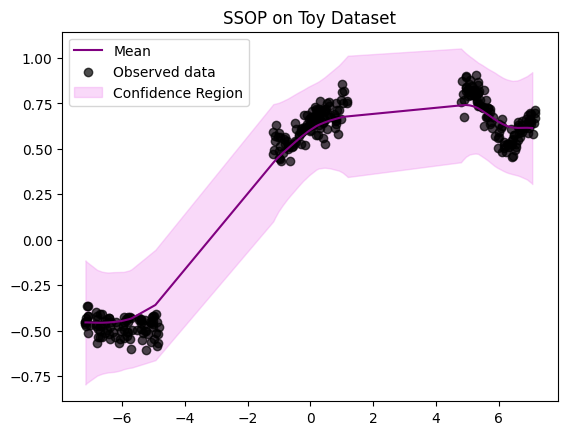

In [15]:
plot_SSGP(x_train_toy, y_train_toy, x_test_toy, ssop_posterior_mean_toy, ssop_posterior_var_toy, title= "SSOP on Toy Dataset")

# Evaluate SSGP optimized

In [16]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Order y_test, x_test
  temporal_order = jnp.argsort(x_test_toy.numpy())
  y_test_temporal_order = y_test_toy.numpy()[temporal_order]
  x_test_temporal_order = x_test_toy.numpy()[temporal_order]

  RMSE_SSOP_toy, NLPD_SSOP_toy, PICP_SSOP_toy, MPIW_SSOP_toy = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(ssop_posterior_mean_toy)),
      torch.tensor(np.array(ssop_posterior_var_toy)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSOP Model: ",RMSE_SSOP_toy)
  print("NLPD SSOP Model: ",NLPD_SSOP_toy)
  print("PICP SSOP Model: ",PICP_SSOP_toy)
  print("MPIW SSOP Model: ",MPIW_SSOP_toy)
  print("Time SSOP Model: ", train_time_SSOP_toy)

RMSE SSOP Model:  0.07856980770741509
NLPD SSOP Model:  tensor(-0.8872, dtype=torch.float64)
PICP SSOP Model:  1.0
MPIW SSOP Model:  0.5472059
Time SSOP Model:  2.5224344730377197


In [17]:
# Train with pytorch instead

# Calculate ell and sigma
opt_ell_toy_torch, opt_sigma_toy_torch, train_time_SSPY_toy = train_SSGP_torch(x_train_toy, y_train_toy, x_test_toy, ell=1, sigma=1)
print("Training Time: ", train_time_SSPY_toy)
# Convert them to numpy arrays
# Assume tensor is on GPU
opt_ell_toy_pytorch = opt_ell_toy_torch.to('cpu')
opt_sigma_toy_pytorch = opt_sigma_toy_torch.to('cpu')

opt_ell_toy_numpy = opt_ell_toy_pytorch.numpy()
opt_sigma_toy_numpy = opt_sigma_toy_pytorch.numpy()
# Calculate mean and variance
mfs_torch, vfs_torch, mps_torch, vps_torch, _ = kalmanFilter(ss_ys_toy, dts_toy, opt_ell_toy_numpy, opt_sigma_toy_numpy, m0=0, v0=1)
mss_torch, vss_torch = kalmanSmoothing(opt_ell_toy_numpy, dts_toy, mfs_torch, vfs_torch, mps_torch, vps_torch)
sspy_posterior_mean_toy = mss_torch[jnp.isnan(ss_ys_toy)]
sspy_posterior_var_toy = vss_torch[jnp.isnan(ss_ys_toy)]



<ipython-input-2-842d7428ac2a>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nlls.append(torch.tensor(nll, requires_grad=True))


Training Time:  10.242656707763672


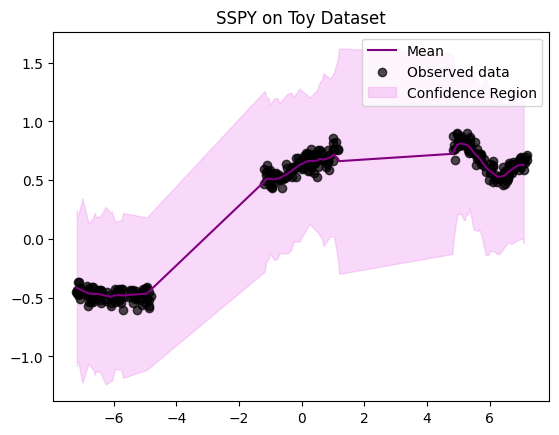

In [18]:
plot_SSGP(x_train_toy, y_train_toy, x_test_toy, sspy_posterior_mean_toy, sspy_posterior_var_toy, title= "SSPY on Toy Dataset")

# Evaluate SSPY

In [19]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  RMSE_SSPY_toy, NLPD_SSPY_toy, PICP_SSPY_toy, MPIW_SSPY_toy = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sspy_posterior_mean_toy)),
      torch.tensor(np.array(sspy_posterior_var_toy)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSPY Model: ",RMSE_SSPY_toy)
  print("NLPD SSPY Model: ",NLPD_SSPY_toy)
  print("PICP SSPY Model: ",PICP_SSPY_toy)
  print("MPIW SSPY Model: ",MPIW_SSPY_toy)
  print("Time SSPY Model: ", train_time_SSPY_toy)

RMSE SSPY Model:  0.06263274057199572
NLPD SSPY Model:  tensor(-0.1546, dtype=torch.float64)
PICP SSPY Model:  1.0
MPIW SSPY Model:  1.3218409
Time SSPY Model:  10.242656707763672


# State Space Model, without optimizer

In [20]:
# Pick hyperparameters on your own:
ell = 3
sigma = 1

start_time = time.time()
mfs2, vfs2, mps2, vps2, _ = kalmanFilter(ss_ys_toy, dts_toy, ell, sigma, m0=0, v0=1)
mss2, vss2 = kalmanSmoothing(ell, dts_toy, mfs2, vfs2, mps2, vps2)
sswo_posterior_mean_toy = mss2[jnp.isnan(ss_ys_toy)]
sswo_posterior_var_toy = vss2[jnp.isnan(ss_ys_toy)]
end_time = time.time()
train_time_SSWO_toy = end_time-start_time


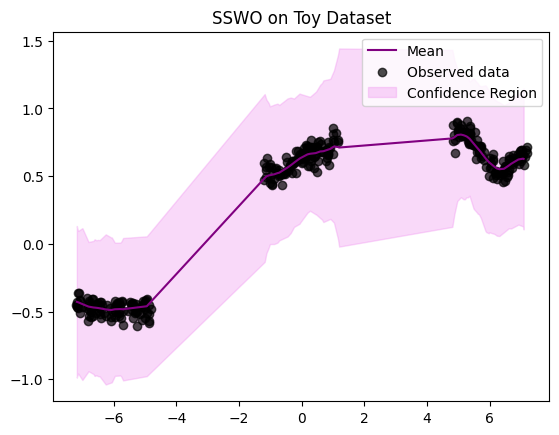

In [21]:
plot_SSGP(x_train_toy, y_train_toy, x_test_toy, sswo_posterior_mean_toy, sswo_posterior_var_toy, title= "SSWO on Toy Dataset")

# Evaluate SSWO

In [22]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():

  RMSE_SSWO_toy, NLPD_SSWO_toy, PICP_SSWO_toy, MPIW_SSWO_toy = error_metrics(
      torch.tensor(x_test_temporal_order),
      torch.tensor(y_test_temporal_order),
      torch.tensor(np.array(sswo_posterior_mean_toy)),
      torch.tensor(np.array(sswo_posterior_var_toy)))# error_metrics defined in utils/functions.ipynb
  print("RMSE SSWO Model: ",RMSE_SSWO_toy)
  print("NLPD SSWO Model: ",NLPD_SSWO_toy)
  print("PICP SSWO Model: ",PICP_SSWO_toy)
  print("MPIW SSWO Model: ",MPIW_SSWO_toy)
  print("Time SSWO Model: ", train_time_SSWO_toy)

RMSE SSWO Model:  0.05999762163478941
NLPD SSWO Model:  tensor(-0.4112, dtype=torch.float64)
PICP SSWO Model:  1.0
MPIW SSWO Model:  1.0116386
Time SSWO Model:  0.33394432067871094


# Inducing Points Model

In [23]:
inducing_likelihood_toy = gpytorch.likelihoods.GaussianLikelihood() # Likelihood
inducing_mean_toy = gpytorch.means.ConstantMean() # Mean
inducing_kernel_toy = gpytorch.kernels.RBFKernel() # Kernel
# Choose random inital inducing points
# Generate a tensor of random indices
indices = torch.randperm(x_train_toy.size(0))
# Select N random rows
inducing_points_amount = 20 # Choose how many inducing points
inducing_points = x_train_toy[indices][:inducing_points_amount]
inducing_model_toy = inducingGP(x_train_toy,
                                 y_train_toy,
                                 inducing_likelihood_toy,
                                 inducing_mean_toy,
                                 inducing_kernel_toy,
                                 inducing_points) # inducingGP defined in utils/Models.ipynb

# Train Inducing Model

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


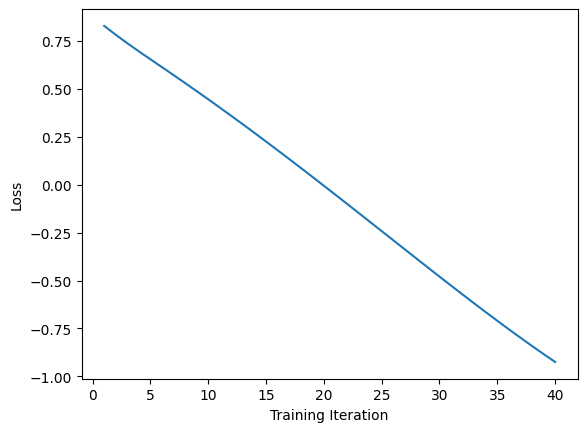

In [24]:
train_time_inducing_toy = train(inducing_model_toy,
                          inducing_likelihood_toy,
                          x_train_toy,
                          y_train_toy,
                          training_iter= 40) # train is defined in utils/functions.ipynb

# Plot Inducing Model

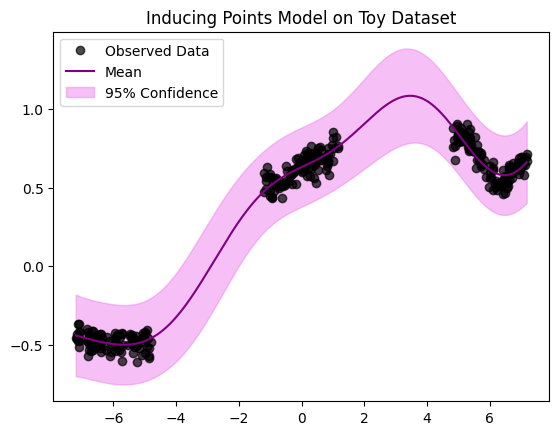

In [25]:
# plotGP defined in utils/functions.ipynb
plotGP(x_train_toy, y_train_toy, inducing_model_toy, inducing_likelihood_toy, "Inducing Points Model on Toy Dataset")

# Plot for Report

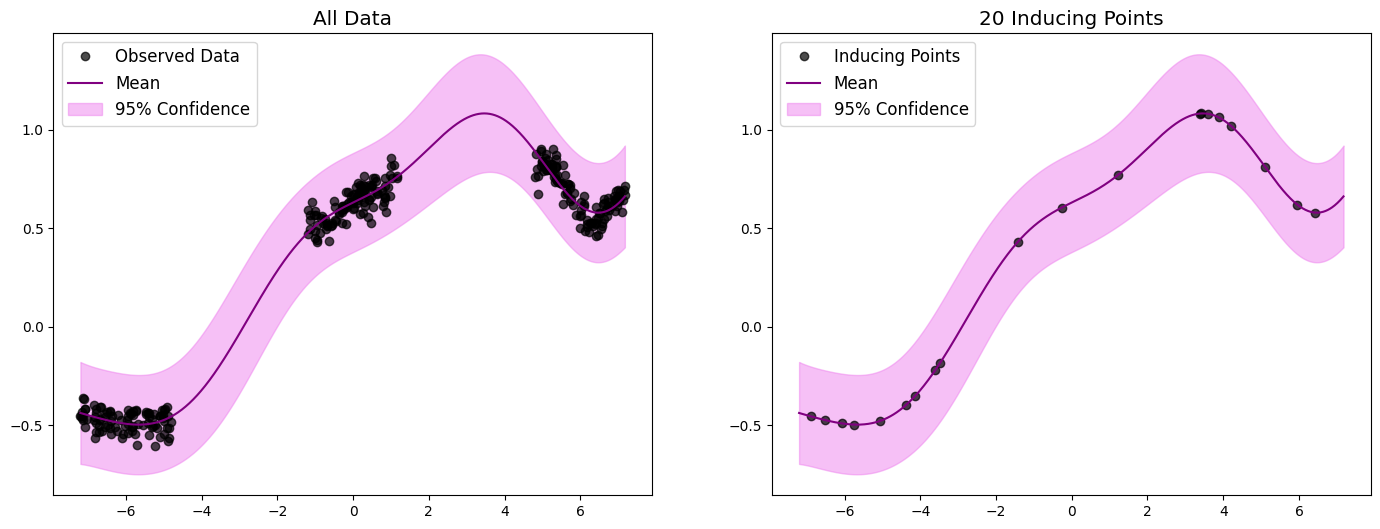

In [26]:
trained_inducing_points_x = inducing_model_toy.covar_module.inducing_points
trained_inducing_points_y = predict(inducing_model_toy, inducing_likelihood_toy,
                                     trained_inducing_points_x) # predict is defined in utils/functions.ipynb¨

# Find min and max value of training set
min_value, max_value = min(x_train_toy), max(x_train_toy)
# Create points between min and max values
x_plot = torch.linspace(min_value, max_value, 1000)
inducing_model_toy.eval(), inducing_likelihood_toy.eval()
# Evaluate on plot values
prediction = inducing_likelihood_toy(inducing_model_toy(x_plot))
inducing_model_toy.train(), inducing_likelihood_toy.train()
mean_inducing = prediction.mean
var_inducing = prediction.variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Initalize plot
  plt.style.use('default')
  # Create a figure and a set of subplots
  fig, ax = plt.subplots(1, 2, figsize=(17, 6))  # 1 row, 2 columns

  # Confidence region
  lower_bound = mean_inducing-(1.96*(np.sqrt(var_inducing)))
  upper_bound = mean_inducing+(1.96*(np.sqrt(var_inducing)))

  ax[0].plot(x_train_toy.detach().numpy(), y_train_toy.detach().numpy(), 'ko', label='Observed Data', alpha=0.7)
  # Plot predictive means
  ax[0].plot(x_plot.detach().numpy(), mean_inducing.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[0].fill_between(x_plot.detach().numpy(), lower_bound.detach().numpy(),
                  upper_bound.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[0].set_title("All Data", fontsize="x-large")
  ax[0].legend(loc = "best", fontsize="large")

  ax[1].plot(trained_inducing_points_x.detach().numpy(), trained_inducing_points_y.mean.detach().numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[1].plot(x_plot.detach().numpy(), mean_inducing.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[1].fill_between(x_plot.detach().numpy(), lower_bound.detach().numpy(),
                  upper_bound.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[1].set_title("20 Inducing Points", fontsize="x-large")
  ax[1].legend(loc = "best", fontsize="large")

  plt.grid(False)
  plt.plot
  #plt.savefig("Inducing_2plots")

# Predict and Evaluate Inducing Model

In [27]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  predictions_inducing_toy = predict(inducing_model_toy, inducing_likelihood_toy,
                                     x_test_toy) # predict is defined in utils/functions.ipynb
  RMSE_inducing_toy, NLPD_inducing_toy, PICP_inducing_toy, MPIW_inducing_toy = error_metrics(
      x_test_toy,
      y_test_toy,
      predictions_inducing_toy.mean,
      predictions_inducing_toy.variance)# error_metrics defined in utils/functions.ipynb



  print("RMSE inducing: ",RMSE_inducing_toy)
  print("NLPD inducing: ",NLPD_inducing_toy)
  print("PICP inducing: ",PICP_inducing_toy)
  print("MPIW inducing: ",MPIW_inducing_toy)
  print("Time inducing: ", train_time_inducing_toy)

RMSE inducing:  0.06259393341975078
NLPD inducing:  tensor(-1.0104, dtype=torch.float64)
PICP inducing:  1.0
MPIW inducing:  0.5061416544307016
Time inducing:  0.27696871757507324


# Display Results

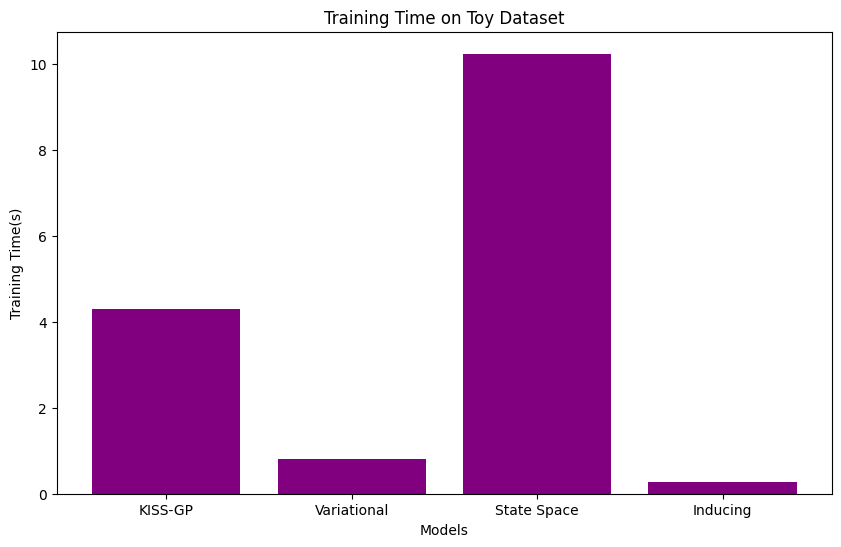

In [28]:
# Training times
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
times_toy = [train_time_KISSGP_toy, train_time_variational_toy, train_time_SSPY_toy, train_time_inducing_toy]
plot_bar(models, times_toy, "Training Time on Toy Dataset", "Models", "Training Time(s)") # plot_bar defined in utils/function.ipynb

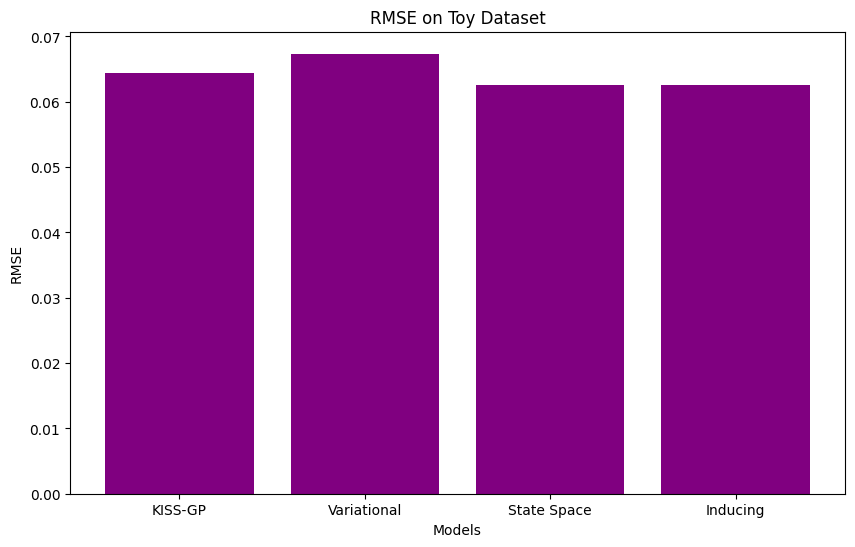

In [29]:
# RMSE
models = ["KISS-GP", "Variational", "State Space","Inducing"]
RMSE_toy = [RMSE_KISSGP_toy, RMSE_variational_toy, RMSE_SSPY_toy, RMSE_inducing_toy]
plot_bar(models, RMSE_toy, "RMSE on Toy Dataset", "Models", "RMSE") # plot_bar defined in utils/function.ipynb

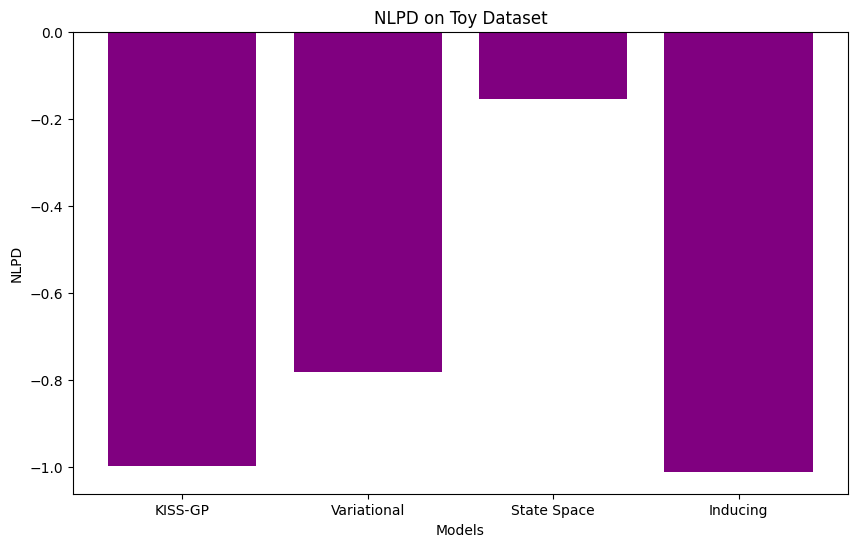

In [30]:
# NLPD
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
NLPD_toy = [NLPD_KISSGP_toy, NLPD_variational_toy, NLPD_SSPY_toy, NLPD_inducing_toy]
plot_bar(models, NLPD_toy, "NLPD on Toy Dataset", "Models", "NLPD") # plot_bar defined in utils/function.ipynb

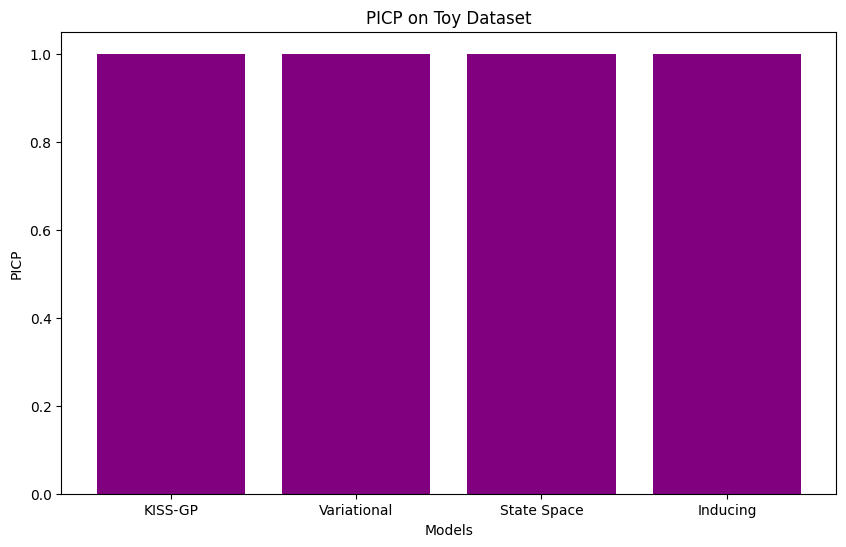

In [31]:
# PICP
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
PICP_toy = [PICP_KISSGP_toy, PICP_variational_toy, PICP_SSPY_toy, PICP_inducing_toy]
plot_bar(models, PICP_toy, "PICP on Toy Dataset", "Models", "PICP") # plot_bar defined in utils/function.ipynb

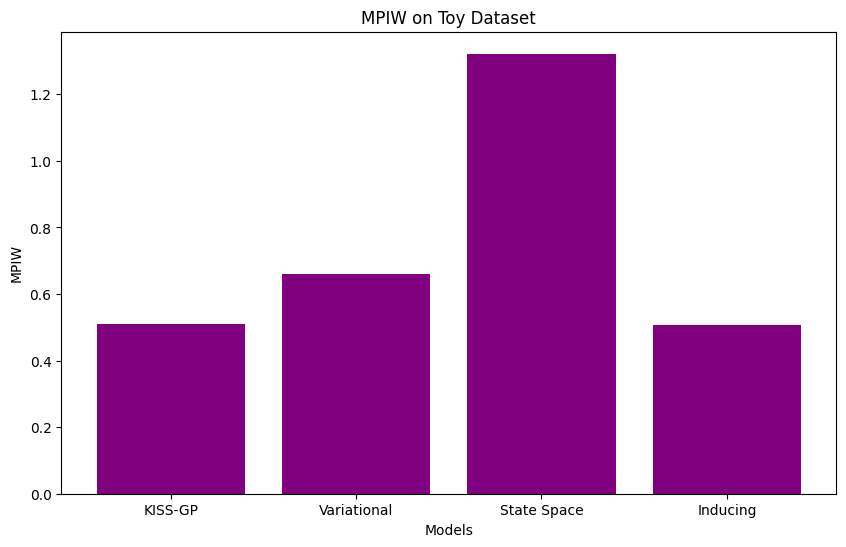

In [32]:
# MPIW
models = ["KISS-GP", "Variational", "State Space", "Inducing"]
MPIW_toy = [MPIW_KISSGP_toy, MPIW_variational_toy, MPIW_SSPY_toy, MPIW_inducing_toy]
plot_bar(models, MPIW_toy, "MPIW on Toy Dataset", "Models", "MPIW") # plot_bar defined in utils/function.ipynb

# Summarize for report

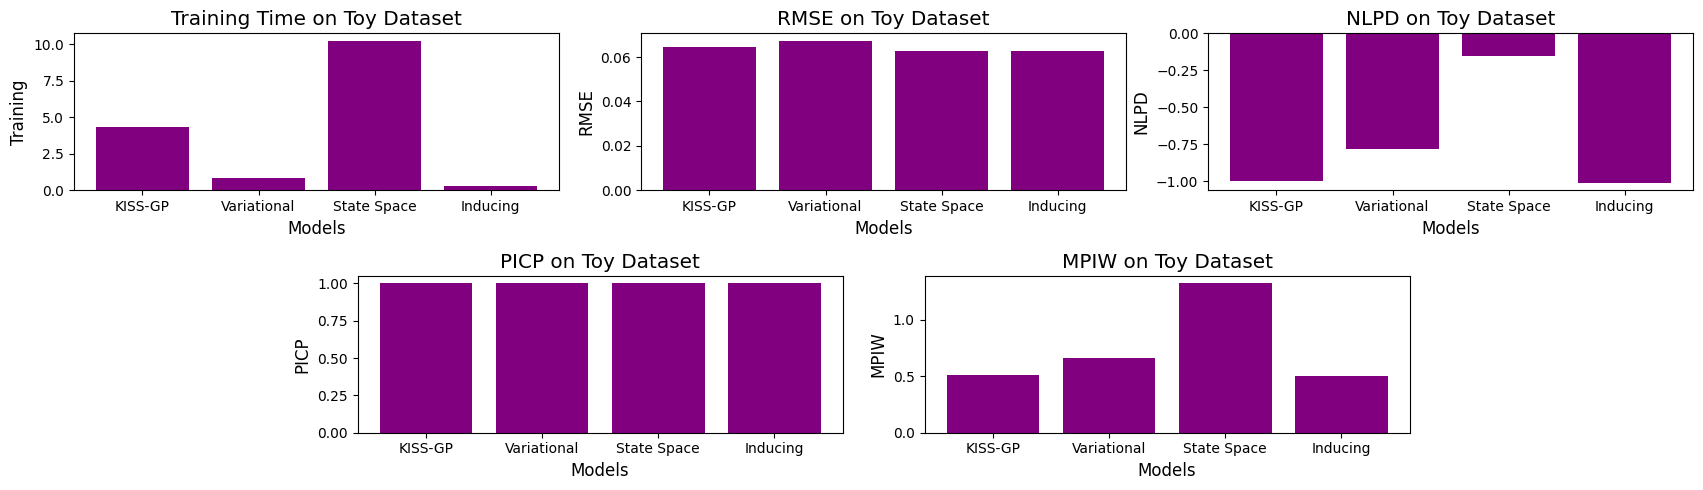

In [33]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(2, 6)  # 2 rows, 6 columns

fig = plt.figure(figsize=(17, 5))

# Create subplots
ax1 = fig.add_subplot(gs[0, 0:2])  # Spans columns 0-1
ax2 = fig.add_subplot(gs[0, 2:4])  # Spans columns 2-3
ax3 = fig.add_subplot(gs[0, 4:6])  # Spans columns 4-5
ax4 = fig.add_subplot(gs[1, 1:3])  # Spans columns 1-2
ax5 = fig.add_subplot(gs[1, 3:5])  # Spans columns 3-4

axes = [ax1, ax2, ax3, ax4, ax5]  # List of axes
data = [times_toy, RMSE_toy, NLPD_toy, PICP_toy, MPIW_toy]  # Replace with your data
titles = ["Training Time on Toy Dataset", "RMSE on Toy Dataset", "NLPD on Toy Dataset", "PICP on Toy Dataset", "MPIW on Toy Dataset"]

# Plot data
for i, ax in enumerate(axes):
    ax.bar(models, data[i], color='purple')
    ax.set_title(titles[i], size = "x-large")
    ax.set_xlabel("Models", size = "large")
    ax.set_ylabel(titles[i].split(" ")[0], size = "large")

plt.tight_layout()
plt.savefig("metrics_toy")
plt.show()


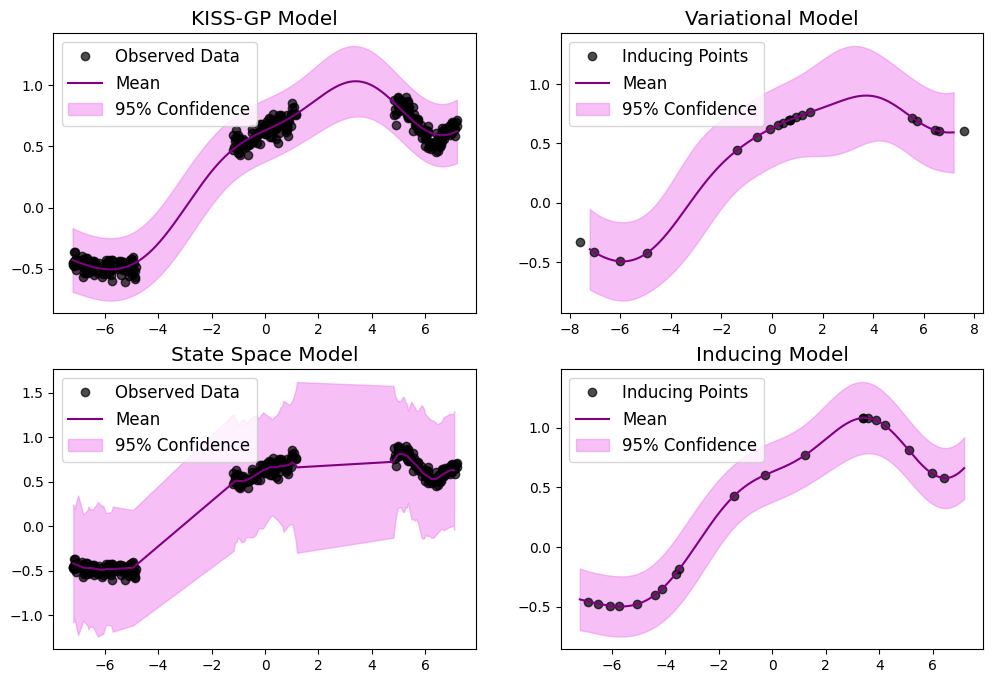

In [34]:
# Initalize plot
plt.style.use('default')
# Create a figure and a set of subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns


# KISS-GP
# Evaluate on plot values
prediction = predict(KISSGP_model_toy, KISSGP_likelihood_toy, x_plot)
mean_KISSGP = prediction.mean
var_KISSGP = prediction.variance
lower_bound_KISSGP = mean_KISSGP-(1.96*(np.sqrt(var_KISSGP)))
upper_bound_KISSGP = mean_KISSGP+(1.96*(np.sqrt(var_KISSGP)))
ax[0,0].plot(x_train_toy, y_train_toy, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
ax[0,0].plot(x_plot.detach().numpy(), mean_KISSGP.detach().numpy(), 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
ax[0,0].fill_between(x_plot.detach().numpy(), lower_bound_KISSGP.detach().numpy(),
                upper_bound_KISSGP.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
ax[0,0].set_title("KISS-GP Model", fontsize="x-large")
ax[0,0].legend(loc = "best", fontsize="large")


# Variational Model
trained_variational_points_x = variational_model_toy.variational_strategy.inducing_points
trained_variational_points_y = predict(variational_model_toy, variational_likelihood_toy,
                                     trained_variational_points_x) # predict is defined in utils/functions.ipynb¨

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  # Evaluate on plot values
  prediction = predict(variational_model_toy, variational_likelihood_toy, x_plot)
  mean_variational = prediction.mean
  var_variational = prediction.variance
  lower_bound_variational = mean_variational-(1.96*(np.sqrt(var_variational)))
  upper_bound_variational = mean_variational+(1.96*(np.sqrt(var_variational)))
  ax[0,1].plot(trained_variational_points_x.numpy(), trained_variational_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[0,1].plot(x_plot.detach().numpy(), mean_variational.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[0,1].fill_between(x_plot.detach().numpy(), lower_bound_variational.detach().numpy(),
                  upper_bound_variational.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[0,1].set_title("Variational Model", fontsize="x-large")
  ax[0,1].legend(loc = "best", fontsize="large")





# Find min and max value of training set
temporal_order = jnp.argsort(x_test_toy.numpy())
x_test_order = x_test_toy.numpy()[temporal_order]
lower_bound_SS = sspy_posterior_mean_toy-(1.96*(np.sqrt(sspy_posterior_var_toy)))
upper_bound_SS = sspy_posterior_mean_toy+(1.96*(np.sqrt(sspy_posterior_var_toy)))
ax[1,0].plot(x_train_toy, y_train_toy, 'ko', label='Observed Data', alpha = 0.7)
# Plot predictive means
ax[1,0].plot(x_test_order, sspy_posterior_mean_toy, 'purple', label='Mean')
# Plot confidence bounds as lightly shaded region
ax[1,0].fill_between(x_test_order, lower_bound_SS,
                upper_bound_SS, alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
ax[1,0].set_title("State Space Model", fontsize="x-large")
ax[1,0].legend(loc = "best", fontsize="large")



# Inducing Model
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  lower_bound_inducing = mean_inducing-(1.96*(np.sqrt(var_inducing)))
  upper_bound_inducing = mean_inducing+(1.96*(np.sqrt(var_inducing)))
  ax[1,1].plot(trained_inducing_points_x.numpy(), trained_inducing_points_y.mean.numpy(), 'ko', label='Inducing Points', alpha = 0.7)
  # Plot predictive means
  ax[1,1].plot(x_plot.detach().numpy(), mean_inducing.detach().numpy(), 'purple', label='Mean')
  # Plot confidence bounds as lightly shaded region
  ax[1,1].fill_between(x_plot.detach().numpy(), lower_bound_inducing.detach().numpy(),
                  upper_bound_inducing.detach().numpy(), alpha=0.5, color="violet", zorder=-1, label ='95% Confidence')
  ax[1,1].set_title("Inducing Model", fontsize="x-large")
  ax[1,1].legend(loc = "best", fontsize="large")


plt.savefig("models_toy")